In [13]:
import os
import NN
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

## Train and Evaluate a single model

### Setup Parameters

In [2]:
ETF = 'DIA' # 'SPY', 'DIA', 'QQQ'
NNtype = 'MLP' # 'MLP', 'RNN', 'PSN'
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype] # SPYfeatures, DIAfeatures, QQQfeatures

### Load Dataframes

In [3]:
traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

### Initialize DataLoaders

In [4]:
features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'

trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

max_ = traindf.Return.max()
min_ = traindf.Return.min()
# traindf = (traindf - min_) / (max_ - min_)
# validdf = (validdf - min_) / (max_ - min_)
# testdf = (testdf - min_) / (max_ - min_)

trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

### Instanciate Model

In [5]:
model = NN.Model(NNtype)
model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            200,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)


### Training

In [6]:
model.train(trainloader, validloader)

[00:08] Epoch 1/200 - Train Loss : 1.030429 / Val Loss : 0.996387
[00:53] Epoch 100/200 - Train Loss : 0.956957 / Val Loss : 1.024519
[01:32] Epoch 200/200 - Train Loss : 0.911525 / Val Loss : 1.042139
Train MAE : 0.6796 | Train MAPE  : 1.9801 | Train RSME : 0.8955 | Train Theil-U 0.7542
Valid MAE : 0.7824 | Valid MAPE  : 1.7248 | Valid RSME : 1.0421 | Valid Theil-U 0.8122


### Evaluation

In [7]:
model.evaluate(testloader, testmu, testsigma)

TypeError: can only concatenate list (not "float") to list

In [8]:
model.evaluate_bis(testloader, testmu, testsigma)

Normalized Test MAE : 0.005594 | Test MAPE  : 128.147648 | Test RMSE : 0.000053 | Test Theil-U 0.800176


### PREDICT

(array([ 2.,  7., 19., 58., 90., 61., 39., 27., 13.,  5.]),
 array([-0.73009849, -0.57947481, -0.42885114, -0.27822747, -0.12760379,
         0.02301988,  0.17364355,  0.32426723,  0.4748909 ,  0.62551457,
         0.77613825]),
 <a list of 10 Patch objects>)

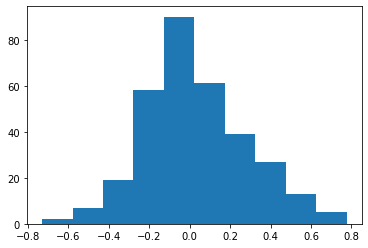

In [9]:
predictions = model.predict(testloader, testmu, testsigma)
plt.hist(np.array(predictions))

RMSE : 1.0084808980640068
MAE : 0.7697181624026368
MAPE : 4.856952879100962
TheilU : 0.8002008225328104


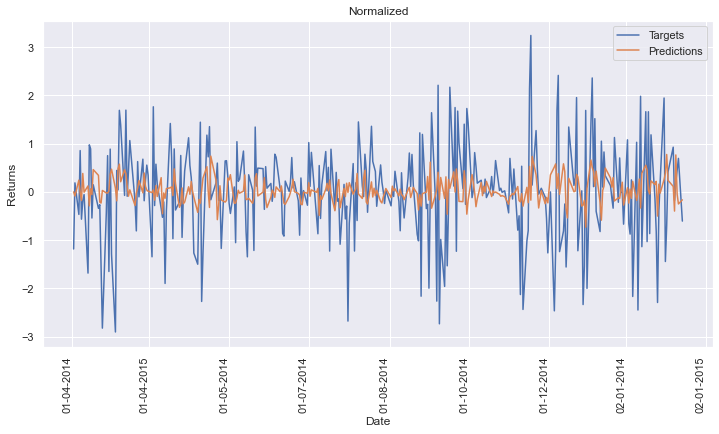

RMSE : 5.3268296231071586e-05
MAE : 0.005594126710943015
MAPE : 1820581.7023715235
TheilU : 0.7935309817688238


Text(0.5, 1.0, 'UnNormalized')

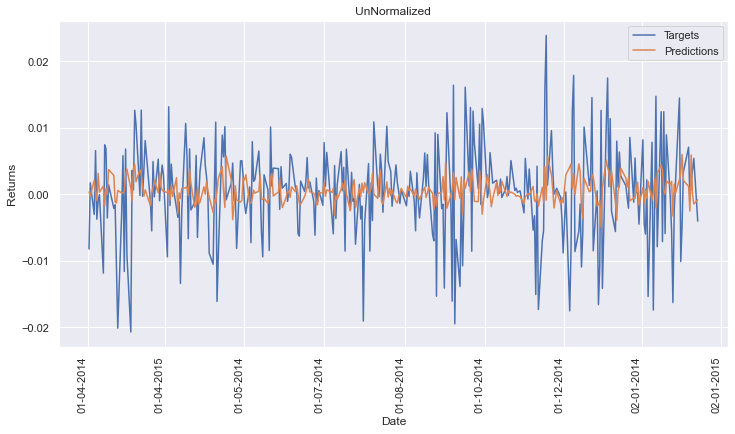

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU
import torch

preds, targets = [], []
model.model.eval()
with torch.no_grad():
    for features, target in testloader:
        if NNtype == "RNN":
            features = features.view(1, features.size(0), features.size(1))
        outputs = model.model(features)
        preds += outputs.numpy().T.tolist()[0]
        targets += target.numpy().tolist()

preds = np.array(preds)
targets = np.array(targets)

print("RMSE :", mean_squared_error(targets, preds))
print("MAE :", mean_absolute_error(targets, preds))
print("MAPE :", mean_absolute_percentage_error(targets, preds))
print("TheilU :", theilU(targets, preds))

## plot Target and Predictions Normalized ##
sns.set()
dataDf = pd.DataFrame({'Predictions':preds, 'Targets':targets})
dataDf.index = testdf.index
dataDf

fig, ax = plt.subplots(figsize = (12,6))
fig = sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

x_dates = dataDf.index.strftime('%d-%m-%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');
ax.set_ylabel('Returns')
ax.set_title("Normalized")
plt.show();


preds = np.array(preds)*testsigma + testmu
targets = np.array(targets)*testsigma + testmu

print("RMSE :", mean_squared_error(targets, preds))
print("MAE :", mean_absolute_error(targets, preds))
print("MAPE :", mean_absolute_percentage_error(targets, preds))
print("TheilU :", theilU(targets, preds))

## plot Target and Predictions UnNormalized ##
dataDf = pd.DataFrame({'Predictions':preds, 'Targets':targets})
dataDf.index = testdf.index
dataDf

fig, ax = plt.subplots(figsize = (12,6))
fig = sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

x_dates = dataDf.index.strftime('%d-%m-%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');
ax.set_ylabel('Returns')
ax.set_title("UnNormalized")

## Train and Evaluate All Models

In [38]:
ETF = 'SPY'
NNtype = 'MLP'  # /!\/!\/!\ tester les PSN /!\/!\/!\

print("="*10 + ETF + " - " + NNtype + "="*10)
params = cfg.train_parameters[ETF][NNtype]
if ETF == "SPY":
    inputs_lag = cfg.SPYfeatures[NNtype]
elif ETF == "DIA":
    inputs_lag = cfg.DIAfeatures[NNtype]
elif ETF == "QQQ":
    inputs_lag = cfg.QQQfeatures[NNtype]

traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'

if NNtype != "PSN":
            
    trainMu, trainSigma = np.mean(traindf.Return.tolist()), np.std(traindf.Return.tolist())
    validMu, validSigma = np.mean(validdf.Return.tolist()), np.std(validdf.Return.tolist())
    testMu, testSigma = np.mean(testdf.Return.tolist()), np.std(testdf.Return.tolist())

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainMu, sigma=trainSigma)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validMu, sigma=validSigma)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testMu, sigma=testSigma)

else:
            
    trainMax_, trainMin_ = np.max(traindf.Return.tolist()), np.min(traindf.Return.tolist())
    validMax_, validMin_ = np.max(validdf.Return.tolist()), np.min(validdf.Return.tolist())
    testMax_, testMin_ = np.max(testdf.Return.tolist()), np.min(testdf.Return.tolist())

    traindf = (traindf -  trainMin_) / (trainMax_ - trainMin_)
    validdf = (validdf -  validMin_) / (validMax_ - validMin_)
    testdf = (testdf - testMin_) / (testMax_ - testMin_)

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

model = NN.Model(NNtype)
model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            500,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

model.train(trainloader, validloader)

==========SPY - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.039464 / Val Loss : 0.995348
[00:33] Epoch 100/500 - Train Loss : 0.921157 / Val Loss : 0.998346
[01:07] Epoch 200/500 - Train Loss : 0.889208 / Val Loss : 1.039760
[01:40] Epoch 300/500 - Train Loss : 0.861769 / Val Loss : 1.120189
[02:12] Epoch 400/500 - Train Loss : 0.834482 / Val Loss : 1.153864
[02:45] Epoch 500/500 - Train Loss : 0.815241 / Val Loss : 1.137364
Train MAE : 0.6501 | Train MAPE  : 2.4506 | Train RSME : 0.8220 | Train Theil-U 0.6156
Valid MAE : 0.8170 | Valid MAPE  : 1.5788 | Valid RSME : 1.1374 | Valid Theil-U 0.7332


Test MAE : 0.006068 | Test MAPE  : 2.209930 | Test RMSE : 0.000065 | Test Theil-U 0.717436


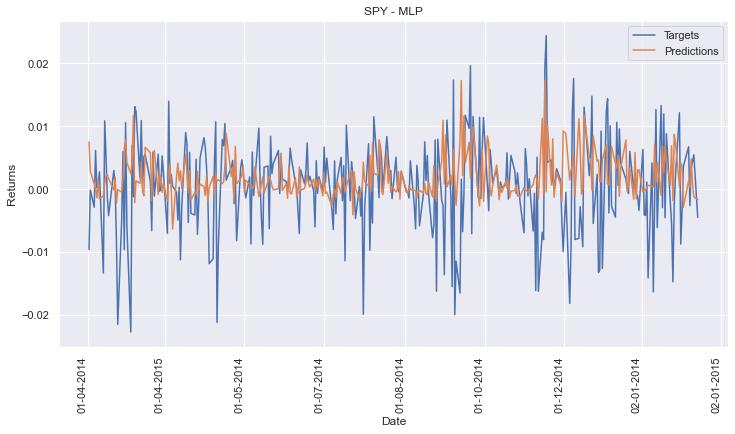

In [44]:
preds = model.predict(testloader, testMu, testSigma)
labels = np.array(testdf['Target'].to_list())

if NNtype != "PSN":
#     labels = testSigma * np.array(labels) + testMu
    preds = testSigma * np.array(preds) + testMu
else :
#     labels = (testMax_ - testMin_) * np.array(labels) + testMin_
    preds = (testMax_ - testMin_) * np.array(preds) + testMin_

testRMSE = mean_squared_error(labels, preds)
testMAE = mean_absolute_error(labels, preds)
testMAPE = mean_absolute_percentage_error(labels, preds)
testTheilU = theilU(labels, preds)

print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))

## plot Target and Predictions UnNormalized ##
dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
dataDf.index = testdf.index
dataDf

fig, ax = plt.subplots(figsize = (12,6))
fig = sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

x_dates = dataDf.index.strftime('%d-%m-%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');
ax.set_ylabel('Returns')
ax.set_title(ETF + " - " + NNtype)
plt.show()

==========SPY - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.050369 / Val Loss : 1.009098
[00:33] Epoch 100/500 - Train Loss : 0.892733 / Val Loss : 1.003541
[01:06] Epoch 200/500 - Train Loss : 0.825264 / Val Loss : 1.080349
[01:40] Epoch 300/500 - Train Loss : 0.791794 / Val Loss : 1.094654
[02:12] Epoch 400/500 - Train Loss : 0.753022 / Val Loss : 1.109690
[02:45] Epoch 500/500 - Train Loss : 0.742350 / Val Loss : 1.135717
Train MAE : 0.6274 | Train MAPE  : 2.6501 | Train RSME : 0.7347 | Train Theil-U 0.5637
Valid MAE : 0.8429 | Valid MAPE  : 1.6428 | Valid RSME : 1.1357 | Valid Theil-U 0.7226
Test MAE : 0.005995 | Test MAPE  : 1.873651 | Test RMSE : 0.000065 | Test Theil-U 0.717916


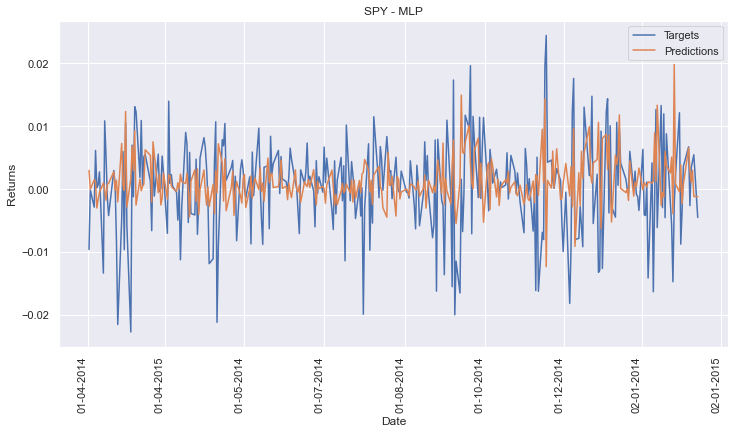




==========SPY - RNN==========
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:01] Epoch 1/500 - Train Loss : 1.092421 / Val Loss : 1.010934
[00:48] Epoch 100/500 - Train Loss : 0.753926 / Val Loss : 1.143647
[01:36] Epoch 200/500 - Train Loss : 0.688826 / Val Loss : 1.216597
[02:26] Epoch 300/500 - Train Loss : 0.679538 / Val Loss : 1.202181
[03:15] Epoch 400/500 - Train Loss : 0.676810 / Val Loss : 1.193675
[04:05] Epoch 500/500 - Train Loss : 0.675265 / Val Loss : 1.191793
Train MAE : 0.6086 | Train MAPE  : 3.0673 | Train RSME : 0.6367 | Train Theil-U 0.5016
Valid MAE : 0.8437 | Valid MAPE  : 2.1230 | Valid RSME : 1.1918 | Valid Theil-U 0.6875
Test MAE : 0.006540 | Test MAPE  : 2.466577 | Test RMSE : 0.000076 | Test Theil-U 0.718493


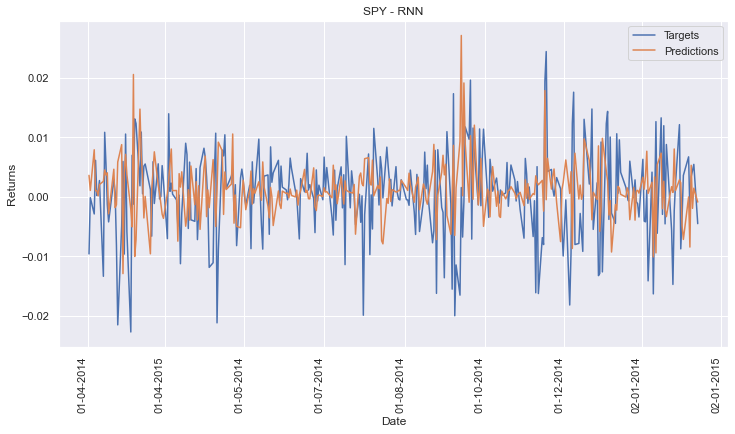




==========SPY - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 0.020832 / Val Loss : 0.019488
[00:38] Epoch 100/500 - Train Loss : 0.012880 / Val Loss : 0.092299
[01:13] Epoch 200/500 - Train Loss : 0.012595 / Val Loss : 0.087385
[01:48] Epoch 300/500 - Train Loss : 0.013130 / Val Loss : 0.075829
[02:24] Epoch 400/500 - Train Loss : 0.171255 / Val Loss : 0.249594
[02:58] Epoch 500/500 - Train Loss : 0.171255 / Val Loss : 0.249594
Train MAE : 0.4004 | Train MAPE  : 1992.7534 | Train RSME : 0.1713 | Train Theil-U 0.2574
Valid MAE : 0.4801 | Valid MAPE  : 3969.4369 | Valid RSME : 0.2496 | Valid Theil-U 0.3248
Test MAE : 0.467840 | Test MAPE  : 77.030207 | Test RMSE : 0.243097 | Test Theil-U 0.911862


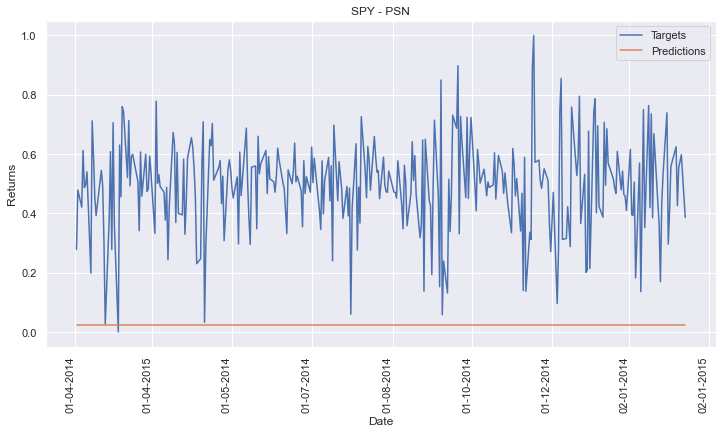




==========DIA - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.018259 / Val Loss : 1.010168
[00:35] Epoch 100/500 - Train Loss : 0.958246 / Val Loss : 1.030640
[01:11] Epoch 200/500 - Train Loss : 0.870396 / Val Loss : 1.055911
[01:48] Epoch 300/500 - Train Loss : 0.748610 / Val Loss : 1.141685
[02:24] Epoch 400/500 - Train Loss : 0.707535 / Val Loss : 1.192371
[03:00] Epoch 500/500 - Train Loss : 0.680494 / Val Loss : 1.259751
Train MAE : 0.6180 | Train MAPE  : 3.0137 | Train RSME : 0.6604 | Train Theil-U 0.5236
Valid MAE : 0.8802 | Valid MAPE  : 2.4393 | Valid RSME : 1.2598 | Valid Theil-U 0.7315
Test MAE : 0.006177 | Test MAPE  : 3.093886 | Test RMSE : 0.000067 | Test Theil-U 0.729440


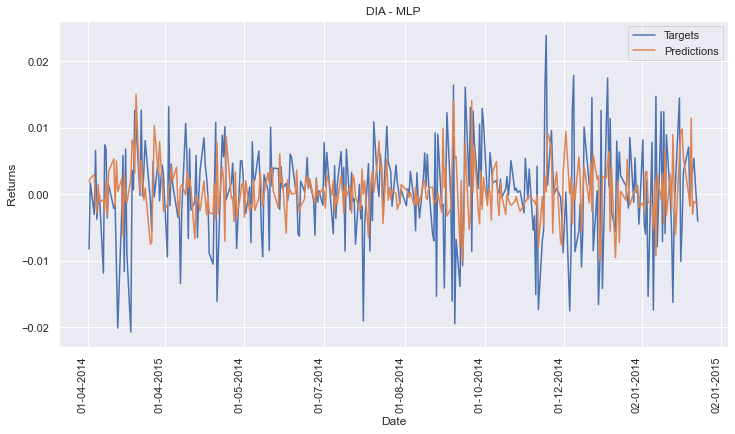




==========DIA - RNN==========
RNN(
  (rnn): RNN(8, 7)
  (fc): Linear(in_features=7, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0.006
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.051674 / Val Loss : 1.005641
[00:50] Epoch 100/500 - Train Loss : 0.776895 / Val Loss : 1.241649
[01:40] Epoch 200/500 - Train Loss : 0.755204 / Val Loss : 1.234896
[02:30] Epoch 300/500 - Train Loss : 0.746522 / Val Loss : 1.230189
[03:22] Epoch 400/500 - Train Loss : 0.741756 / Val Loss : 1.229089
[04:12] Epoch 500/500 - Train Loss : 0.738835 / Val Loss : 1.228742
Train MAE : 0.6118 | Train MAPE  : 2.7825 | Train RSME : 0.7035 | Train Theil-U 0.5526
Valid MAE : 0.8613 | Valid MAPE  : 2.4984 | Valid RSME : 1.2287 | Valid Theil-U 0.7228
Test MAE : 0.006377 | Test MAPE  : 8.644177 | Test RMSE : 0.000067 | Test Theil-U 0.722316


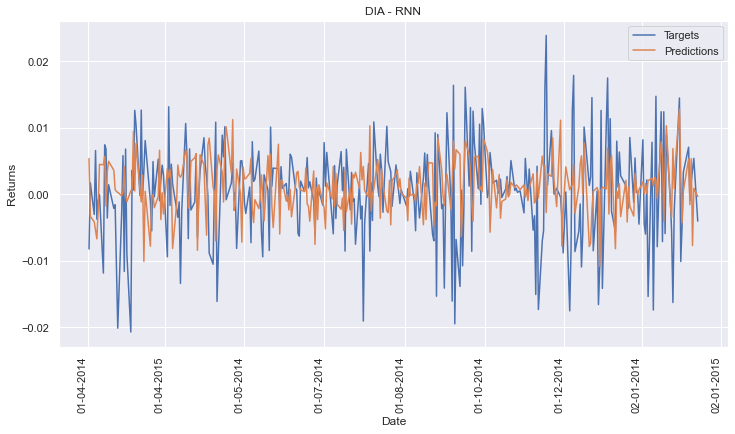




==========DIA - PSN==========
PSN(
  (fc): Linear(in_features=7, out_features=6, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 0.017098 / Val Loss : 0.018654
[00:34] Epoch 100/500 - Train Loss : 0.013789 / Val Loss : 0.057689
[01:08] Epoch 200/500 - Train Loss : 0.013163 / Val Loss : 0.063159
[01:43] Epoch 300/500 - Train Loss : 0.013266 / Val Loss : 0.064516
[02:17] Epoch 400/500 - Train Loss : 0.016723 / Val Loss : 0.081632
[02:52] Epoch 500/500 - Train Loss : 0.181060 / Val Loss : 0.253037
Train MAE : 0.4104 | Train MAPE  : 1992.8122 | Train RSME : 0.1811 | Train Theil-U 0.2659
Valid MAE : 0.4850 | Valid MAPE  : 3969.3493 | Valid RSME : 0.2530 | Valid Theil-U 0.3283
Test MAE : 0.449448 | Test MAPE  : 65.596304 | Test RMSE : 0.228544 | Test Theil-U 0.913520


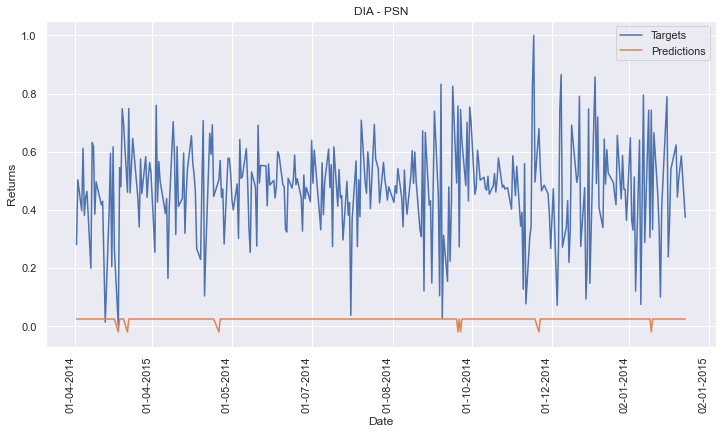




==========QQQ - MLP==========
Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.042924 / Val Loss : 1.003612
[00:35] Epoch 100/500 - Train Loss : 0.933385 / Val Loss : 0.990251
[01:13] Epoch 200/500 - Train Loss : 0.805560 / Val Loss : 1.032000
[01:49] Epoch 300/500 - Train Loss : 0.756358 / Val Loss : 1.118902
[02:24] Epoch 400/500 - Train Loss : 0.735643 / Val Loss : 1.174323
[03:00] Epoch 500/500 - Train Loss : 0.708056 / Val Loss : 1.238456
Train MAE : 0.6428 | Train MAPE  : 2.6653 | Train RSME : 0.6748 | Train Theil-U 0.5338
Valid MAE : 0.8398 | Valid MAPE  : 4.4845 | Valid RSME : 1.2385 | Valid Theil-U 0.7457
Test MAE : 0.007439 | Test MAPE  : 27.844714 | Test RMSE : 0.000098 | Test Theil-U 0.727189


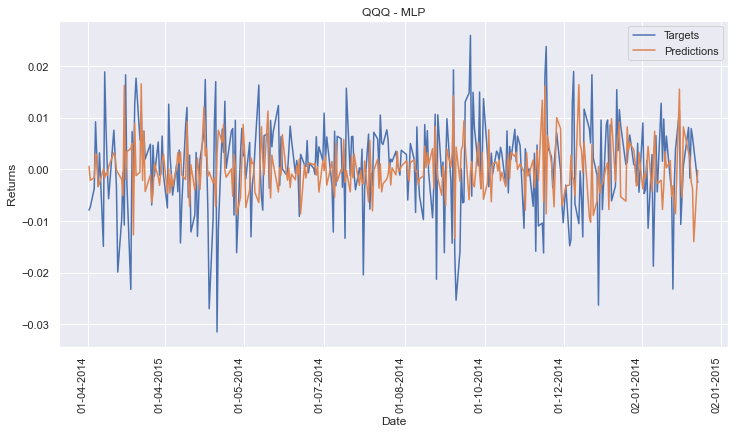




==========QQQ - RNN==========
RNN(
  (rnn): RNN(8, 10)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.014138 / Val Loss : 0.997243
[00:50] Epoch 100/500 - Train Loss : 0.788200 / Val Loss : 1.276207
[01:42] Epoch 200/500 - Train Loss : 0.666961 / Val Loss : 1.471647
[02:33] Epoch 300/500 - Train Loss : 0.633379 / Val Loss : 1.554015
[03:24] Epoch 400/500 - Train Loss : 0.623069 / Val Loss : 1.596745
[04:16] Epoch 500/500 - Train Loss : 0.618309 / Val Loss : 1.595362
Train MAE : 0.6072 | Train MAPE  : 3.2233 | Train RSME : 0.5914 | Train Theil-U 0.4701
Valid MAE : 0.9784 | Valid MAPE  : 5.2763 | Valid RSME : 1.5954 | Valid Theil-U 0.7372
Test MAE : 0.008051 | Test MAPE  : 36.094870 | Test RMSE : 0.000114 | Test Theil-U 0.716570


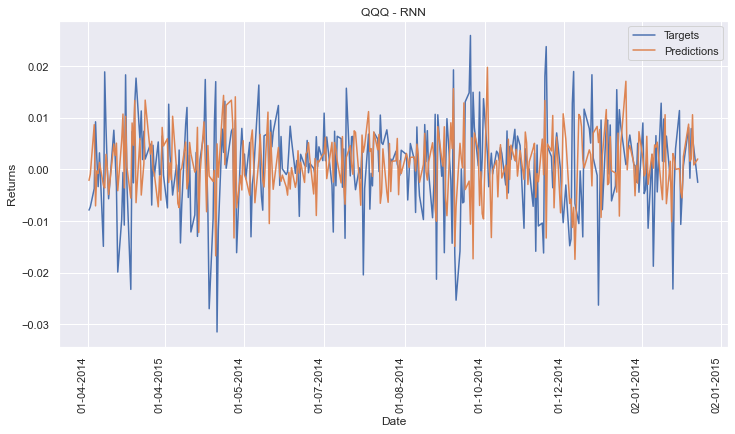




==========QQQ - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=8, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 0.018489 / Val Loss : 0.021138
[00:34] Epoch 100/500 - Train Loss : 0.014333 / Val Loss : 0.068053
[01:09] Epoch 200/500 - Train Loss : 0.014145 / Val Loss : 0.110249
[01:44] Epoch 300/500 - Train Loss : 0.013876 / Val Loss : 0.120599
[02:19] Epoch 400/500 - Train Loss : 0.014132 / Val Loss : 0.148353
[02:54] Epoch 500/500 - Train Loss : 0.013986 / Val Loss : 0.143720
Train MAE : 0.0905 | Train MAPE  : 1106.0577 | Train RSME : 0.0138 | Train Theil-U 0.1033
Valid MAE : 0.3357 | Valid MAPE  : 3579.5131 | Valid RSME : 0.1437 | Valid Theil-U 0.2978
Test MAE : 0.559061 | Test MAPE  : 3.736645 | Test RMSE : 0.335797 | Test Theil-U 0.991101


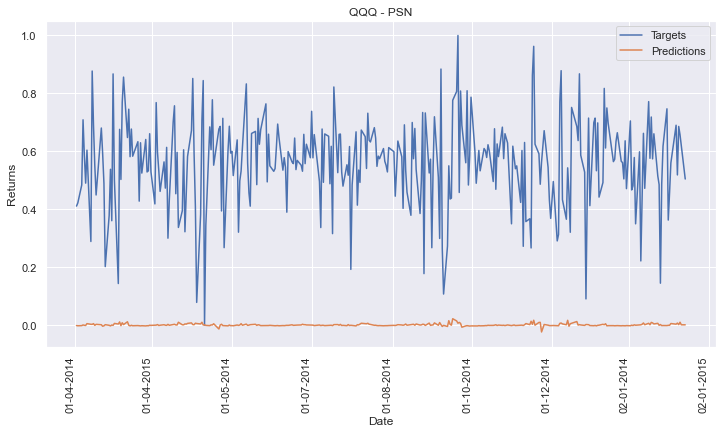

In [45]:
Table4 = pd.DataFrame()

models = {'SPY':{'MLP':None,'RNN':None,'PSN':None},
          'DIA':{'MLP':None,'RNN':None,'PSN':None},
          'QQQ':{'MLP':None,'RNN':None,'PSN':None},
         }

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        print("="*10 + ETF + " - " + NNtype + "="*10)
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        elif ETF == "QQQ":
            inputs_lag = cfg.QQQfeatures[NNtype]

        traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
        validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
        testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        
        if NNtype != "PSN":
            
            trainMu, trainSigma = np.mean(traindf.Return.tolist()), np.std(traindf.Return.tolist())
            validMu, validSigma = np.mean(validdf.Return.tolist()), np.std(validdf.Return.tolist())
            testMu, testSigma = np.mean(testdf.Return.tolist()), np.std(testdf.Return.tolist())

            trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainMu, sigma=trainSigma)
            validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validMu, sigma=validSigma)
            testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testMu, sigma=testSigma)

        else:
            
            trainMax_, trainMin_ = np.max(traindf.Return.tolist()), np.min(traindf.Return.tolist())
            validMax_, validMin_ = np.max(validdf.Return.tolist()), np.min(validdf.Return.tolist())
            testMax_, testMin_ = np.max(testdf.Return.tolist()), np.min(testdf.Return.tolist())

            traindf = (traindf -  trainMin_) / (trainMax_ - trainMin_)
            validdf = (validdf -  validMin_) / (validMax_ - validMin_)
            testdf = (testdf - testMin_) / (testMax_ - testMin_)
            
            trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
            validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
            testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)


            
        model = NN.Model(NNtype)
        model.setup(params["input_size"], 
                    params["hidden_size"],
                    params["output_size"],
                    500,#params["epochs"],
                    params["optim"],
                    params["lr"],
                    params["momentum"]
                   )

        model.train(trainloader, validloader)
        #model.evaluate(testloader)
        
        # /!\ /!\ /!\ /!\ /!\ /!\ /!\ /!\ /!\ #
        # /!\ /!\ /!\ /!\ /!\ /!\ /!\ /!\ /!\ #
        preds = model.predict(testloader, testMu, testSigma)
        labels = np.array(testdf['Target'].to_list())
        
        # /!\ /!\ /!\ /!\ /!\ /!\ /!\ /!\ /!\ #
        # /!\ /!\ /!\ /!\ /!\ /!\ /!\ /!\ /!\ #
        
        if NNtype != "PSN":
#             labels = testSigma * np.array(labels) + testMu
            preds = testSigma * np.array(preds) + testMu
        else :
#             labels = (testMax_ - testMin_) * np.array(labels) + testMin_
            preds = (testMax_ - testMin_) * np.array(preds) + testMin_
        
        testRMSE = mean_squared_error(labels, preds)
        testMAE = mean_absolute_error(labels, preds)
        testMAPE = mean_absolute_percentage_error(labels, preds)
        testTheilU = theilU(labels, preds)

        print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))
        
        ## plot Target and Predictions UnNormalized ##
        dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
        dataDf.index = testdf.index
        dataDf

        fig, ax = plt.subplots(figsize = (12,6))
        fig = sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
        sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

        x_dates = dataDf.index.strftime('%d-%m-%Y').sort_values().unique()
        ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');
        ax.set_ylabel('Returns')
        ax.set_title(ETF + " - " + NNtype)
        plt.show()
        
        models[ETF][NNtype] = model
        
        Table[NNtype] = [testMAE, testMAPE, testRMSE, testTheilU]
        Table["ETF"] = ETF 
        print("\n"*2)
     
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
# Table4.to_csv("table/Table4norm.csv", index=True) 

### Save Models

In [9]:
for ETF in ["SPY", "DIA", "QQQ"]:
    for NNtype in ["MLP", "RNN", "PSN"]:
        os.makedirs(os.path.join("models_norm", ETF, NNtype), exist_ok=True)
        save_model(models[ETF][NNtype].model.state_dict(), os.path.join("models_norm", ETF, NNtype, "ckpt.pth"))

### Load Ckpt

In [71]:
ETF = "DIA"
NNtype = "MLP"
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype]

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'
df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)

modelloaded = NN.Model(NNtype)
modelloaded.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            1000,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )
modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
modelloaded.evaluate(dataloader)

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Test MAE : 0.005390 | Test MAPE  : 3.646229 | Test RSME : 0.000052 | Test Theil-U 0.926919


# To work

# Generating Table 4

In [ ]:
Table4 = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)
        
        modelloaded = NN.Model(NNtype)
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          1000,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
        modelloaded.evaluate(dataloader)
        
        Table[NNtype] = [modelloaded.testMAE, modelloaded.testMAPE, modelloaded.testRMSE, modelloaded.testTheilU]
        Table["ETF"] = ETF
    
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
Table4.to_csv("table/Table4norm.csv", index=True)        

In [10]:
ypred, ytrue, evaluation = modelloaded.Getevaluation(dataloader)

In [14]:
import numpy as np
y_pred = np.array(ypred)
y_true = np.array(ytrue)

In [51]:
modelloaded.evaluate(dataloader)

Test MAE : 0.005624 | Test MAPE  : inf | Test RSME : 0.000054 | Test Theil-U 0.769070


In [20]:
np.abs((y_true - y_pred)/y_true)

array([5.97504411e-01, 8.19620566e-01, 7.61992324e-01, 1.27961111e+00,
       1.55741931e+00, 1.06965293e+00, 4.08921429e+01, 1.03007374e+00,
       1.17004060e+00, 7.15264093e-01, 6.79977365e-01, 1.38981662e+00,
       5.70637783e-01, 2.21547445e+00, 1.06259083e+00, 8.27917005e-01,
       1.34271908e+00, 1.28133038e+00, 9.69783017e-01, 6.09123871e-01,
       1.31316356e+00, 1.12362061e+00, 4.03105552e-01, 3.35606941e+00,
       7.98431427e-01, 6.87432206e-01, 7.31159248e-01, 3.80845850e-01,
       1.51305376e+00, 1.29509997e+00, 7.20141230e-01, 3.29434595e+00,
       1.13785257e+00, 1.49065573e+00, 3.72291052e+00, 7.72002016e-01,
       6.24651569e-01, 8.43269646e-01, 5.24755104e-01, 1.34105122e+00,
       1.07121130e+00, 9.88006366e-01, 8.68172943e-01, 1.04517050e+00,
       3.42294065e-01, 4.86738036e-01, 1.53935203e+00, 2.25559896e-01,
       8.57544100e-01, 1.52026479e+00, 1.25801378e+00, 6.77532215e-01,
       1.29784225e+00, 7.91556409e-01, 2.08852883e+00, 1.93345424e+00,
      

In [30]:
y_true[y_true == 0] = 0.000006

In [31]:
np.where(y_true == 0)

(array([], dtype=int64),)

In [12]:
Table4

NameError: name 'Table4' is not defined